In [2]:
import sys
sys.path.append("../src")
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
from data_loader import load_track_json_files, extract_mood_labeled_tracks, map_tags_to_mood
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import os
import pandas as pd

# Paths
folder_path = "../data/raw/features/features"
annotations_path = "../data/raw/features/annotations/static_annotations_averaged_songs_1_2000.csv"

all_features = {}

# Step 1: Aggregate features per song
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath, sep=';')
        
        numeric_df = df.select_dtypes(include=['number'])
        
        if 'frameTime' in numeric_df.columns:
            numeric_df = numeric_df.drop(columns=['frameTime'])
        
        cols_to_remove = [col for col in numeric_df.columns if '_de_' in col]
        numeric_df = numeric_df.drop(columns=cols_to_remove)
        
        feature_means = numeric_df.mean()
        feature_stds = numeric_df.std()
        
        feature_vector = pd.concat([feature_means, feature_stds], axis=0)
        
        track_id = os.path.splitext(filename)[0]
        all_features[track_id] = feature_vector

features_df = pd.DataFrame.from_dict(all_features, orient='index')

# de test
# print(f"Aggregated features shape: {features_df.shape}")
# print(features_df.head())

# Step 2: Load annotations
annotations_df = pd.read_csv(annotations_path)

# Strip any whitespace from column names
annotations_df.columns = annotations_df.columns.str.strip()

# de test
# print("Annotations columns:", annotations_df.columns.tolist())
# print(f"Annotations shape: {annotations_df.shape}")
# print(annotations_df.head())

# Step 3: Prepare annotations for merging
annotations_df = annotations_df.rename(columns={'song_id': 'track_id'})

# Reset index on features_df so track_id is a column
features_df = features_df.reset_index().rename(columns={'index': 'track_id'})

# Ensure track_id columns are strings and stripped (optional but safer)
features_df['track_id'] = features_df['track_id'].astype(str).str.strip()
annotations_df['track_id'] = annotations_df['track_id'].astype(str).str.strip()

# Step 4: Merge features with annotations on 'track_id'
merged_df = pd.merge(features_df, annotations_df, on='track_id', how='inner')

# de test
# print(f"Merged dataset shape: {merged_df.shape}")
print(merged_df.columns.tolist())
# print(merged_df[['track_id', 'valence_mean', 'arousal_mean']].head())

# Step 5: Normalize valence and arousal means to [0,1] for thresholding
val_min, val_max = merged_df['valence_mean'].min(), merged_df['valence_mean'].max()
aro_min, aro_max = merged_df['arousal_mean'].min(), merged_df['arousal_mean'].max()

merged_df['valence_norm'] = (merged_df['valence_mean'] - val_min) / (val_max - val_min)
merged_df['arousal_norm'] = (merged_df['arousal_mean'] - aro_min) / (aro_max - aro_min)

def assign_mood(valence, arousal, threshold=0.5):
    if valence >= threshold and arousal >= threshold:
        return 'happy'
    elif valence >= threshold and arousal < threshold:
        return 'calm'
    elif valence < threshold and arousal >= threshold:
        return 'angry'
    else:
        return 'sad'

merged_df['mood'] = merged_df.apply(lambda row: assign_mood(row['valence_norm'], row['arousal_norm']), axis=1)
print(merged_df[['track_id', 'valence_mean', 'arousal_mean', 'valence_norm', 'arousal_norm', 'mood']].head(10))

# Save merged dataset if needed
# merged_df.to_csv('features_with_annotations.csv', index=False)


['track_id', 'F0final_sma_stddev', 'F0final_sma_amean', 'voicingFinalUnclipped_sma_stddev', 'voicingFinalUnclipped_sma_amean', 'jitterLocal_sma_stddev', 'jitterLocal_sma_amean', 'jitterDDP_sma_stddev', 'jitterDDP_sma_amean', 'shimmerLocal_sma_stddev', 'shimmerLocal_sma_amean', 'logHNR_sma_stddev', 'logHNR_sma_amean', 'audspec_lengthL1norm_sma_stddev', 'audspec_lengthL1norm_sma_amean', 'audspecRasta_lengthL1norm_sma_stddev', 'audspecRasta_lengthL1norm_sma_amean', 'pcm_RMSenergy_sma_stddev', 'pcm_RMSenergy_sma_amean', 'pcm_zcr_sma_stddev', 'pcm_zcr_sma_amean', 'audSpec_Rfilt_sma[0]_stddev', 'audSpec_Rfilt_sma[0]_amean', 'audSpec_Rfilt_sma[1]_stddev', 'audSpec_Rfilt_sma[1]_amean', 'audSpec_Rfilt_sma[2]_stddev', 'audSpec_Rfilt_sma[2]_amean', 'audSpec_Rfilt_sma[3]_stddev', 'audSpec_Rfilt_sma[3]_amean', 'audSpec_Rfilt_sma[4]_stddev', 'audSpec_Rfilt_sma[4]_amean', 'audSpec_Rfilt_sma[5]_stddev', 'audSpec_Rfilt_sma[5]_amean', 'audSpec_Rfilt_sma[6]_stddev', 'audSpec_Rfilt_sma[6]_amean', 'audSpec

k neighbors per class: {np.int64(0): 22, np.int64(1): 23, np.int64(2): 19, np.int64(3): 19}
Mutual kNN graph edges before MST: 7765
Mutual kNN graph not connected, adding MST edges for connectivity...
Final graph edges after MST: 8437
Is final graph connected? True
Data object with mutual kNN + MST graph: Data(x=[1744, 210], edge_index=[2, 8437], y=[1744])


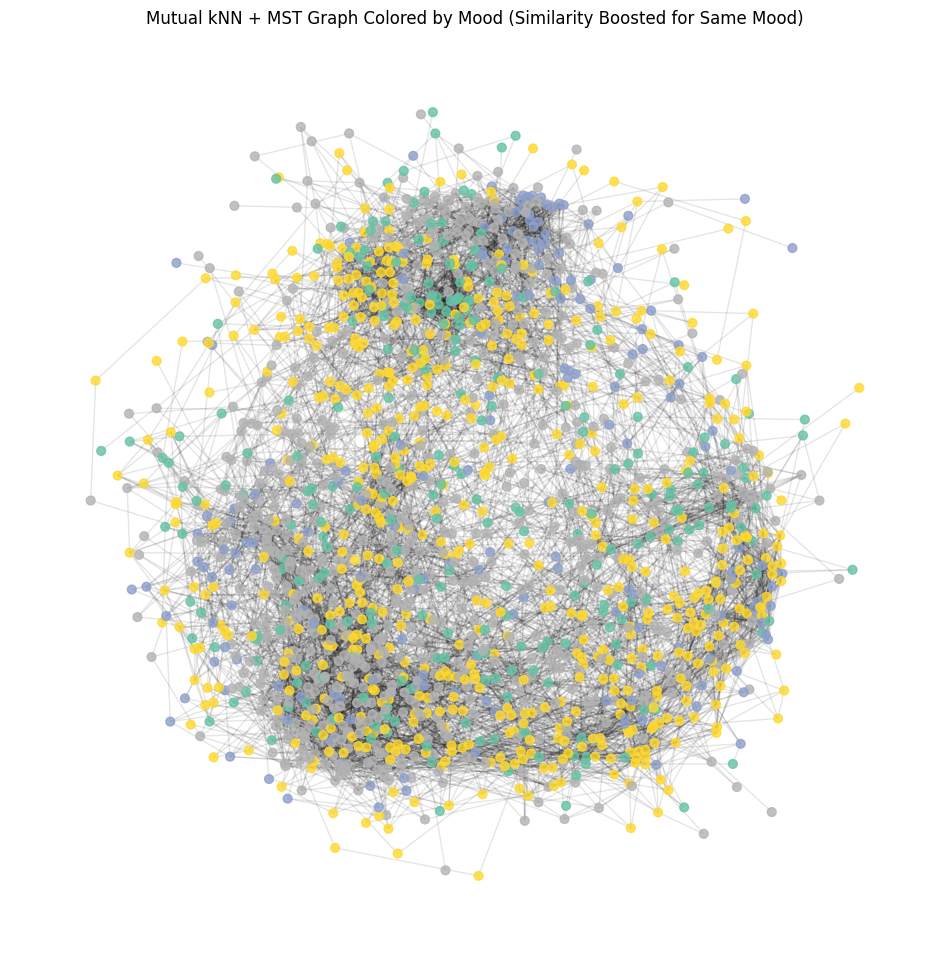

In [66]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

# Assuming merged_df is ready and you excluded columns as before:
exclude_cols = [
    'track_id', 'valence_mean', 'valence_std',
    'arousal_mean', 'arousal_std', 'valence_norm',
    'arousal_norm', 'mood'
]

feature_cols = [col for col in merged_df.columns if col not in exclude_cols]

# Features and labels
X = merged_df[feature_cols].values
labels = merged_df['mood'].values

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

num_nodes = X_normalized.shape[0]
similarity_matrix = cosine_similarity(X_normalized)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Compute class frequencies
unique_classes, counts = np.unique(labels_encoded, return_counts=True)
total_samples = len(labels_encoded)
class_freq = {c: count / total_samples for c, count in zip(unique_classes, counts)}

# Define min and max k
min_k = 10
max_k = 25

# Compute per-class k based on inverse frequency (rarer class → higher k)
k_per_class = {}
for c in unique_classes:
    freq = class_freq[c]
    k_per_class[c] = int(min_k + (1 - freq) * (max_k - min_k))

print("k neighbors per class:", k_per_class)

# Adjust similarity by mood match factor before neighbor selection
adjusted_similarity = similarity_matrix.copy()
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if labels_encoded[i] == labels_encoded[j]:
            # Boost similarity if same mood
            adjusted_similarity[i, j] *= 1.2
            adjusted_similarity[j, i] = adjusted_similarity[i, j]
        else:
            # Leave similarity as is or optionally scale down slightly (not applied here)
            pass

# Find top-k neighbors per node with dynamic k by class on adjusted similarity
top_k_neighbors = []
for i in range(num_nodes):
    node_class = labels_encoded[i]
    k_for_node = k_per_class[node_class]

    sim_scores = adjusted_similarity[i].copy()
    sim_scores[i] = -1  # exclude self
    neighbors = np.argsort(sim_scores)[::-1][:k_for_node]
    top_k_neighbors.append(set(neighbors))

# Build mutual kNN edges
mutual_knn_edges = set()
for i in range(num_nodes):
    for j in top_k_neighbors[i]:
        if i in top_k_neighbors[j]:  # mutual condition
            edge = tuple(sorted((i, j)))
            mutual_knn_edges.add(edge)

print(f"Mutual kNN graph edges before MST: {len(mutual_knn_edges)}")

# Create graph from mutual kNN edges
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(mutual_knn_edges)

# Check connectivity and add MST edges if disconnected
if not nx.is_connected(G):
    print("Mutual kNN graph not connected, adding MST edges for connectivity...")

    distance_matrix = 1 - similarity_matrix  # Use original similarity for MST
    G_full = nx.Graph()
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G_full.add_edge(i, j, weight=distance_matrix[i, j])

    mst = nx.minimum_spanning_tree(G_full)

    for edge in mst.edges():
        if not G.has_edge(*edge):
            G.add_edge(*edge)

print(f"Final graph edges after MST: {G.number_of_edges()}")
print(f"Is final graph connected? {nx.is_connected(G)}")

# Prepare PyTorch Geometric data object
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
X_tensor = torch.tensor(X_normalized, dtype=torch.float)
labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)

data = Data(x=X_tensor, edge_index=edge_index, y=labels_tensor)
print(f"Data object with mutual kNN + MST graph: {data}")

# Visualize graph colored by mood
unique_moods = np.unique(labels)
color_map = plt.get_cmap('Set2', len(unique_moods))
mood_to_color = {mood: color_map(i) for i, mood in enumerate(unique_moods)}
node_colors = [mood_to_color[mood] for mood in labels]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.15)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title("Mutual kNN + MST Graph Colored by Mood (Similarity Boosted for Same Mood)")
plt.axis('off')
plt.show()


In [67]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Prepare masks and data once (unchanged)
num_nodes = data.num_nodes
labels_tensor = data.y  # encoded labels

all_indices = list(range(num_nodes))
train_idx, test_idx = train_test_split(
    all_indices, test_size=0.2, random_state=42, stratify=labels_tensor.cpu().numpy())
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.25, random_state=42, stratify=labels_tensor[train_idx].cpu().numpy())

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Define model class
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.7):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits[mask].argmax(dim=1)
        acc = accuracy_score(data.y[mask].cpu(), preds.cpu())
    return acc

# Fixed hyperparameters
hidden_dim = 32
lr = 0.01
dropout = 0.7
num_epochs = 100

model = GraphSAGE(
    input_dim=data.num_node_features,
    hidden_dim=hidden_dim,
    output_dim=len(torch.unique(labels_tensor)),
    dropout=dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

val_acc_history = []
test_acc_history = []
best_val_acc = 0
best_test_acc = 0

for epoch in range(1, num_epochs + 1):
    loss = train(model, optimizer)
    val_acc = evaluate(model, data.val_mask)
    test_acc = evaluate(model, data.test_mask)

    val_acc_history.append(val_acc)
    test_acc_history.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

mean_val_acc = np.mean(val_acc_history)
mean_test_acc = np.mean(test_acc_history)

print(f"Training with hidden_dim={hidden_dim}, lr={lr}, dropout={dropout}")
print(f"Mean Val Acc: {mean_val_acc:.4f}, Mean Test Acc: {mean_test_acc:.4f}")
print(f"Best Val Acc: {best_val_acc:.4f}, Corresponding Test Acc: {best_test_acc:.4f}")


Epoch 001, Loss: 1.5008, Val Acc: 0.3782, Test Acc: 0.3754
Epoch 010, Loss: 1.0810, Val Acc: 0.6562, Test Acc: 0.6246
Epoch 020, Loss: 0.9225, Val Acc: 0.6819, Test Acc: 0.6447
Epoch 030, Loss: 0.8439, Val Acc: 0.7020, Test Acc: 0.6590
Epoch 040, Loss: 0.7727, Val Acc: 0.7020, Test Acc: 0.6705
Epoch 050, Loss: 0.7317, Val Acc: 0.7106, Test Acc: 0.6619
Epoch 060, Loss: 0.6769, Val Acc: 0.7077, Test Acc: 0.6504
Epoch 070, Loss: 0.6687, Val Acc: 0.7393, Test Acc: 0.6848
Epoch 080, Loss: 0.6122, Val Acc: 0.7249, Test Acc: 0.6791
Epoch 090, Loss: 0.5761, Val Acc: 0.7593, Test Acc: 0.6791
Epoch 100, Loss: 0.5698, Val Acc: 0.7278, Test Acc: 0.6762
Training with hidden_dim=32, lr=0.01, dropout=0.7
Mean Val Acc: 0.7029, Mean Test Acc: 0.6589
Best Val Acc: 0.7593, Corresponding Test Acc: 0.6791


In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import torch

# Assuming merged_df is your DataFrame with all data and columns

# 1. Define feature columns: exclude IDs and labels
exclude_cols = [
    'track_id', 'valence_mean', 'valence_std',
    'arousal_mean', 'arousal_std', 'valence_norm',
    'arousal_norm', 'mood'
]
feature_cols = [col for col in merged_df.columns if col not in exclude_cols]

# 2. Extract features matrix
X = merged_df[feature_cols].values

# Optional: convert to torch tensor if you use PyTorch Geometric
X_tensor = torch.tensor(X, dtype=torch.float)

# === Graph 1: Cosine Similarity Threshold Graph ===

# Compute cosine similarity matrix (shape: num_nodes x num_nodes)
similarity_matrix = cosine_similarity(X)

# Set threshold for edge creation
cosine_threshold = 0.85  # tune this

# Find edges where similarity > threshold (exclude self loops)
edges_cosine = np.argwhere((similarity_matrix > cosine_threshold) & (np.eye(similarity_matrix.shape[0]) == 0))

print(f"Cosine similarity graph edges: {edges_cosine.shape[0]}")

# Convert to PyTorch edge_index (shape [2, num_edges])
edge_index_cosine = torch.tensor(edges_cosine, dtype=torch.long).t().contiguous()

# === Graph 2: k-Nearest Neighbors Graph ===

k = 5  # tune k as needed

knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')  # +1 for self
knn.fit(X)

distances, indices = knn.kneighbors(X)

edge_list_knn = []
num_nodes = X.shape[0]

for i in range(num_nodes):
    # Skip first neighbor since it is the node itself (distance 0)
    for neighbor in indices[i][1:]:
        edge_list_knn.append([i, neighbor])

print(f"kNN graph edges: {len(edge_list_knn)}")

edge_index_knn = torch.tensor(edge_list_knn, dtype=torch.long).t().contiguous()

# === Summary ===
print(f"Features matrix shape: {X.shape}")
print(f"Cosine similarity edges shape: {edge_index_cosine.shape}")
print(f"kNN edges shape: {edge_index_knn.shape}")

# === Example: Creating PyG Data objects (if using PyTorch Geometric) ===

from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

# Encode moods as labels (integer)
le = LabelEncoder()
labels = le.fit_transform(merged_df['mood'])
labels_tensor = torch.tensor(labels, dtype=torch.long)

data_cosine = Data(x=X_tensor, edge_index=edge_index_cosine, y=labels_tensor)
data_knn = Data(x=X_tensor, edge_index=edge_index_knn, y=labels_tensor)

print(f"Data object with cosine similarity graph: {data_cosine}")
print(f"Data object with kNN graph: {data_knn}")

# Now you can train and compare your GNN model on these two graphs to see which edge construction works better.


Cosine similarity graph edges: 2664132
kNN graph edges: 8720
Features matrix shape: (1744, 210)
Cosine similarity edges shape: torch.Size([2, 2664132])
kNN edges shape: torch.Size([2, 8720])
Data object with cosine similarity graph: Data(x=[1744, 210], edge_index=[2, 2664132], y=[1744])
Data object with kNN graph: Data(x=[1744, 210], edge_index=[2, 8720], y=[1744])


In [45]:
# Set path to your subset
folder = "../data/raw/lastfm_subset"

# Load all JSON track files
all_tracks = load_track_json_files(folder)

# Filter to only mood-related tracks
mood_tracks = extract_mood_labeled_tracks(all_tracks)

# Assign mood label
for t in mood_tracks:
    t["mood"] = map_tags_to_mood(t["tags"])

In [46]:
df = pd.DataFrame(mood_tracks)
print(f"Found {len(df)} mood-tagged tracks.")
df = df[df["mood"].notna()]
print(f"Tracks with valid mood labels: {len(df)}")

audio_df = pd.read_csv("../features.csv")

merged_df = pd.merge(df, audio_df, on="track_id", how="inner")
print(f"Matched {len(merged_df)} mood-labeled tracks with audio features.")

clean_df = merged_df[
    (merged_df["tempo"] > 0) &
    (merged_df["loudness"] != 0) &
    (merged_df["key"] != -1) &
    (merged_df["mode"].isin([0, 1])) &
    (merged_df["duration"] > 0)
].dropna()

print(f"Cleaned dataset size: {len(clean_df)}")
# for col in merged_df.columns:
#     if not merged_df[col].apply(lambda x: isinstance(x, list)).any():
#         print(f"Unique values in {col}: {merged_df[col].unique()}")
#     else:
#         print(f"Skipped column '{col}' (contains lists)")


Found 2111 mood-tagged tracks.
Tracks with valid mood labels: 2104
Matched 2104 mood-labeled tracks with audio features.
Cleaned dataset size: 2100


In [47]:
feature_cols = ["tempo", "loudness", "duration", "key", "mode", "time_signature"]
X = clean_df[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Isolated songs: 0


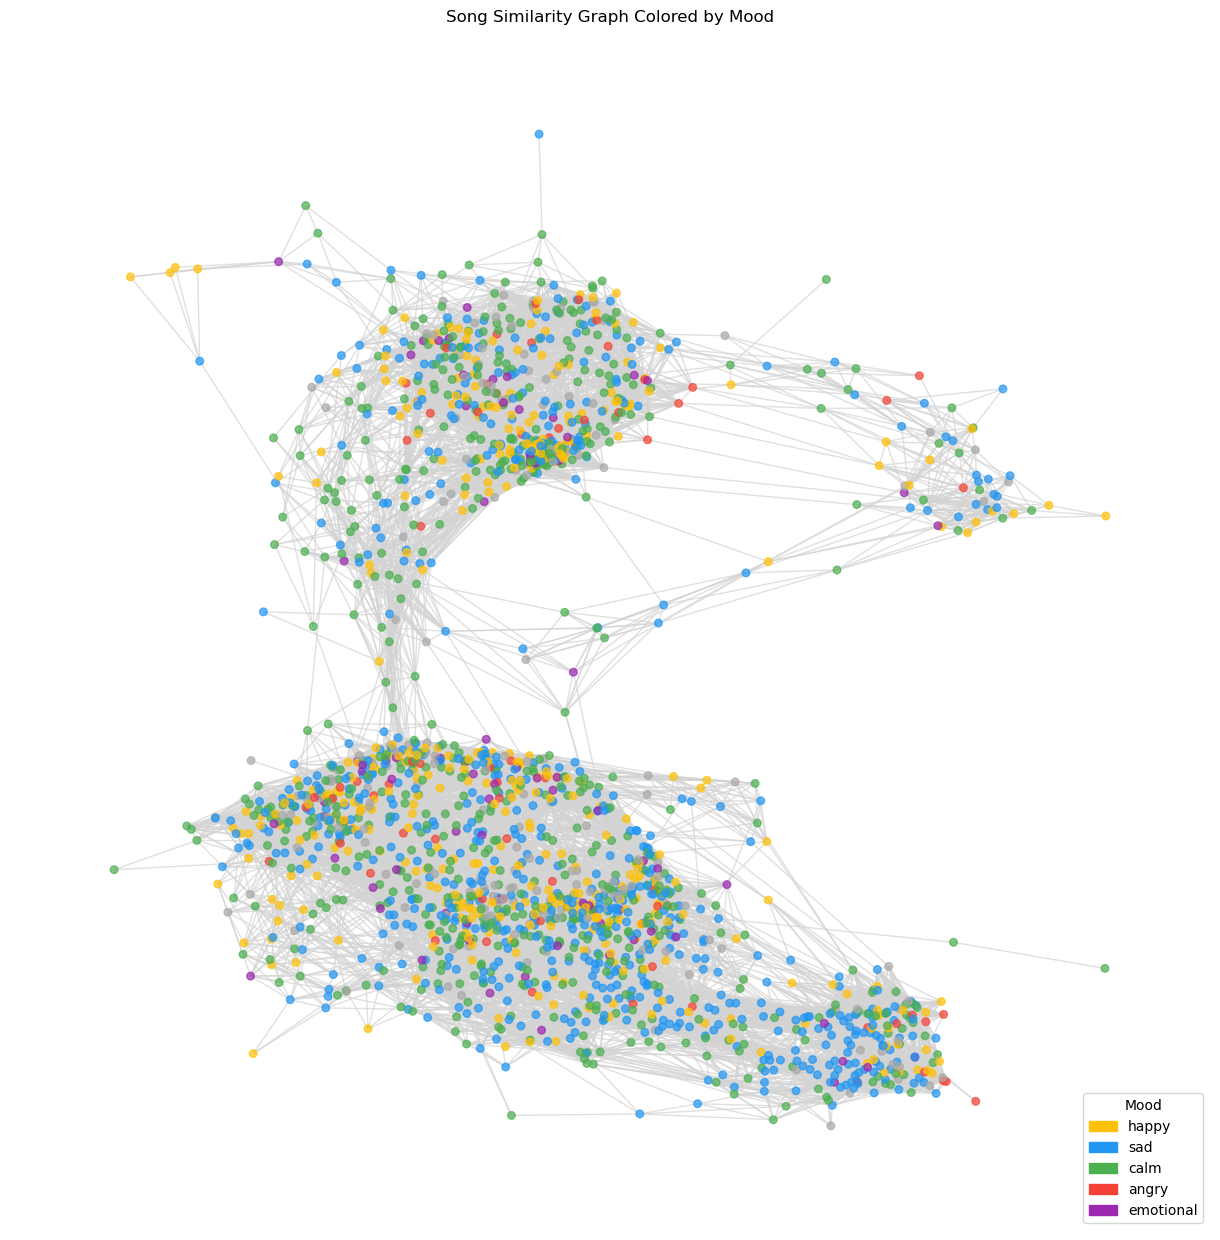

In [49]:
similarity_matrix = cosine_similarity(X_scaled)

G = nx.Graph()

for idx, row in clean_df.iterrows():
    G.add_node(row["track_id"], 
               title=row["title"], 
               artist=row["artist"], 
               mood=row["mood"])

track_ids = clean_df["track_id"].values
threshold = 0.865  # experiment with this later

for i in range(len(track_ids)):
    for j in range(i + 1, len(track_ids)):
        sim = similarity_matrix[i, j]
        if sim > threshold:
            G.add_edge(track_ids[i], track_ids[j], weight=sim)


isolated = list(nx.isolates(G))
print(f"Isolated songs: {len(isolated)}")

fixed_color_map = {
    "happy": "#FFC107",      # amber
    "sad": "#2196F3",        # blue
    "calm": "#4CAF50",       # green
    "angry": "#F44336",      # red
    "emotional": "#9C27B0"   # purple
}

# Step 2: Get node colors based on mood
node_colors = []
for node in G.nodes:
    mood = G.nodes[node].get("mood")
    node_colors.append(fixed_color_map.get(mood, "#A9A9A9"))  # gray as fallback

# Step 3: Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_spring(G, 
               node_color=node_colors,
               node_size=30, 
               edge_color='lightgray', 
               alpha=0.7,
               with_labels=False)
plt.title("Song Similarity Graph Colored by Mood")

legend_handles = [mpatches.Patch(color=color, label=mood) for mood, color in fixed_color_map.items()]
plt.legend(handles=legend_handles, title="Mood", loc="lower right", frameon=True)

plt.show()

#continue with GNN
#organise the code chunks into scripts

In [31]:
from torch_geometric.utils import from_networkx
import torch

# Add 'features' attribute to each node
for idx, row in clean_df.iterrows():
    G.nodes[row["track_id"]]["features"] = X.loc[idx].values.tolist()

# Map mood labels to integers
mood_labels = {label: i for i, label in enumerate(sorted(clean_df["mood"].unique()))}
for node in G.nodes:
    G.nodes[node]["label"] = mood_labels[G.nodes[node]["mood"]]

# Convert NetworkX to PyG Data
from torch_geometric.data import Data
data = from_networkx(G)

# Set features and labels
data.x = torch.tensor([G.nodes[n]["features"] for n in G.nodes], dtype=torch.float)
data.y = torch.tensor([G.nodes[n]["label"] for n in G.nodes], dtype=torch.long)


In [32]:
num_nodes = data.num_nodes
indices = list(range(num_nodes))
random.shuffle(indices)

split = int(0.8 * num_nodes)
train_idx = indices[:split]
test_idx = indices[split:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.test_mask = test_mask

In [33]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=data.x.shape[1], hidden_dim=32, output_dim=len(mood_labels)).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(8000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # if epoch % 20 == 0:
    #     print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [42]:
model.eval()
pred = model(data).argmax(dim=1)

correct = pred[data.test_mask] == data.y[data.test_mask]
acc = int(correct.sum()) / int(data.test_mask.sum())
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.3095
